# Plotting: Models

This notebook is used to generate all the "model" plots (results and analysis on trained models) in the paper.

## Setup

In [1]:
plot_dir = "../plots"
data_base = "../data"
save_dir = data_base + "/models"

num_samples = 11000
seed = 20220615

In [2]:
import os
import functools
from typing import Optional
from tqdm import tqdm

from util.data import Database, ArrayDataset
from util.models import SimpleTripletSplitConvModel, AETripletSplitConvModel

import pickle

2024-01-15 10:47:12.129114: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress TF info/warning messages
import tensorflow_addons as tfa

from matplotlib.colors import LogNorm # For plotting with log-scaled colormaps

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns

#palette = 'colorblind'
colors = [
    (190, 15, 52),
    (72, 145, 220),
    (0, 119, 112),
    (207, 122, 48),
    (235, 196, 203),
]
colors_hex = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in colors]

colors_gradient = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in
    [
        (235, 196, 203),
        (190, 15, 52),
        (135, 36, 52)
    ]
]
colors_gradient_str = ','.join(colors_gradient)
palette_gradient = sns.color_palette(f"blend:{colors_gradient_str}", as_cmap=True)

colors_gradient_blue = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in
    [
        (158, 206, 235),
        (72, 145, 220),
        (0, 33, 71),
    ]
]
colors_gradient_str_blue = ','.join(colors_gradient_blue)
palette_gradient_blue = sns.color_palette(f"blend:{colors_gradient_str_blue}", as_cmap=True)

sns.set_theme(palette=colors_hex, color_codes=True)
sns.set_style('ticks')
sns.set_context('notebook')
sns.color_palette(colors_hex)

plt.rcParams['figure.dpi'] = 72

## Helpers: Models

Functions for loading and unloading models and their checkpoints.

In [5]:
models = [
    dict(
        name='ae-triplet',
        label='Base Model',
        autoencoder=True,
        downsampling=None,
        dataset='shuffled',
    )
]

In [6]:
def load_model(model_params, checkpoint='final'):
    """
    Create and load a model from the given parameters.

    Args:
        model_params (dict): Parameters for the model.
        checkpoint (str, optional): Checkpoint to load, defaults to 'final'.

    Returns:
        model (tf.keras.Model): Loaded model.
    """
    learning_rate = 1e-5
    model_samples = num_samples
    if model_params['downsampling'] is not None:
        model_samples = (model_samples + model_params['downsampling'] - 1) // model_params['downsampling']

    if model_params['autoencoder']:
        model = AETripletSplitConvModel(
            model_params['name'],
            model_samples,
            2,
            [
                (64, 2),
                (64, 4),
                (32, 8),
                (32, 16),
                (32, 32),
                (32, 32),
            ],
            512,
            learning_rate,
            normalization='L2',
            save_dir=save_dir
        )
    else:
        model = SimpleTripletSplitConvModel(
            model_params['name'],
            model_samples,
            2,
            [
                (64, 2),
                (64, 4),
                (32, 8),
                (32, 16),
                (32, 32),
                (32, 32),
            ],
            512,
            learning_rate,
            normalization='L2',
            save_dir=save_dir
        )

    model.load_model(checkpoint)

    return model

In [7]:
def unload_model(model):
    """
    Unload a model and clear the session.

    Args:
        model (tf.keras.Model): Model to unload.
    """
    del model
    tf.keras.backend.clear_session()

In [8]:
model = load_model(models[0])

2024-01-15 10:47:16.177401: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-15 10:47:16.178476: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-01-15 10:47:17.011617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:82:00.0 name: TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2024-01-15 10:47:17.011656: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-01-15 10:47:17.013811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-01-15 10:47:17.013857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-01-15 1

## Helpers: Plotting

Here we define helpers for all our later plotting functions.

In [9]:
# Decorator to add optional output_pdf and show arguments to plot functions
def plot(func):
    @functools.wraps(func)
    def wrapper(*args, output_pdf=None, dpi=None, show=True, **kwargs):
        res = func(*args, **kwargs)

        if output_pdf is not None:
            if dpi is None:
                plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight')
            else:
                plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight', dpi=dpi)
        if show:
            plt.show()
        plt.close()

        return res

    return wrapper

In [75]:
@plot
def plot_distances(distances_all: dict[float, np.ndarray], distances_zero: Optional[np.ndarray] = None, percentile: float = 95, draw_line: bool = True, draw_crossing: bool = False, legend: bool = True):
    # Ensure keys are sorted
    distances_all = { k: distances_all[k] for k in sorted(distances_all.keys()) }
    keys = list(distances_all.keys())
    means = np.array([np.mean(distances_all[i]) for i in keys])
    medians = np.array([np.median(distances_all[i]) for i in keys])
    # 90th percentile, lower and upper
    percentile_upper = np.array([np.percentile(distances_all[i], percentile) for i in keys])
    percentile_lower = np.array([np.percentile(distances_all[i], 100 - percentile) for i in keys])
    ax = sns.lineplot(x=keys, y=medians, color=colors_hex[0])
    ax = sns.lineplot(x=keys, y=means, color=colors_hex[0], linestyle='dotted')
    ax.fill_between(keys, percentile_lower, percentile_upper, alpha=0.2, label=f"{percentile}th percentile")

    ax.lines[0].set_label("Median")
    ax.lines[1].set_label("Mean")

    # Draw the 95th percentile in the 0 noise case
    if draw_line:
        if distances_zero is not None:
            percentile_line = np.percentile(distances_zero, percentile)
        else:
            percentile_line = percentile_upper[0]
        #sns.lineplot(x=keys, y=[percentile_line] * len(keys), linestyle='--')
        plt.axhline(percentile_line, linestyle='--', color='gray')

        ax.lines[2].set_linestyle("--")
        ax.lines[2].set_label(f"Threshold")

    # Draw the point at which the 95th percentile line crosses the mean
    crossing_point = None
    if draw_crossing:
        if distances_zero is not None:
            percentile_line = np.percentile(distances_zero, percentile)
        else:
            percentile_line = percentile_upper[0]

        for k1, v1, k2, v2 in zip(keys, medians, keys[1:], medians[1:]):
            if v1 <= percentile_line and v2 >= percentile_line:
                x = k1 + (k2 - k1) * (percentile_line - v1) / (v2 - v1)
                y = percentile_line
                # Draw a marker at the crossing point
                #plt.axvline(x, linestyle='--', color='black', alpha=0.5)
                ax.plot([x], [y], marker='o', markersize=5, color=colors_hex[0])

                crossing_point = x
                break

    if legend:
        ax.legend(loc='upper left')

    plt.xlabel("Attacker vs victim power (dB)")
    plt.ylabel("Fingerprint distance")

    # Set x ticks to tens, based on keys rounded to tens
    xticks_min = min(keys) // 10 * 10
    xticks_max = max(keys) // 10 * 10 + 20
    xticks = np.arange(xticks_min, xticks_max, 10)
    xtick_labels = [f"{x:.0f}" for x in xticks]
    # If draw_crossing, add an x tick at the crossing point
    #if crossing_point is not None:
    #    xticks = np.append(xticks, crossing_point)
    #    xtick_labels = np.append(xtick_labels, f"{crossing_point:.1f}")
    plt.xticks(xticks, xtick_labels)

In [79]:
@plot
def plot_distances_multiple(distances: dict[str, dict[float, np.ndarray]], distances_zero: Optional[np.ndarray] = None, percentile: float = 95, draw_line: bool = True, draw_crossing: bool = False, legend: bool = True, draw_percentile: bool = True, median: bool = False):
    ax = None

    #hatches = ['//', '\\\\', '||', '--', '+', 'x', 'o', 'O', '.', '*']
    #hatch_index = 0

    crossing_points = []
    for name, distances_all in distances.items():
        # Ensure keys are sorted
        distances_all = { k: distances_all[k] for k in sorted(distances_all.keys()) }
        keys = list(distances_all.keys())
        if median:
            avgs = np.array([np.median(distances_all[i]) for i in keys])
        else:
            avgs = np.array([np.mean(distances_all[i]) for i in keys])
        # 90th percentile, lower and upper
        percentile_upper = np.array([np.percentile(distances_all[i], percentile) for i in keys])
        percentile_lower = np.array([np.percentile(distances_all[i], 100 - percentile) for i in keys])
        if ax is None:
            ax = sns.lineplot(x=keys, y=avgs)
        else:
            sns.lineplot(x=keys, y=avgs, ax=ax)
        if draw_percentile:
            ax.fill_between(keys, percentile_lower, percentile_upper, alpha=0.2)
            #ax.fill_between(keys, percentile_lower, percentile_upper, alpha=0.3, hatch=hatches[hatch_index], edgecolor=colors_hex[hatch_index], facecolor='none')
            #hatch_index += 1

        # Set label
        ax.lines[-1].set_label(name)

        # Draw the point at which the 95th percentile line crosses the mean
        if draw_crossing:
            if distances_zero is not None:
                percentile_line = np.percentile(distances_zero, percentile)
            else:
                percentile_line = percentile_upper[0]

            for k1, v1, k2, v2 in zip(keys, avgs, keys[1:], avgs[1:]):
                if v1 <= percentile_line and v2 >= percentile_line:
                    x = k1 + (k2 - k1) * (percentile_line - v1) / (v2 - v1)
                    y = percentile_line
                    # Draw a marker at the crossing point, in the same color as the line
                    ax.plot([x], [y], marker='o', markersize=5, color=ax.lines[-1].get_color(), zorder=3)

                    crossing_points.append(x)
                    break

    # Draw the 95th percentile in the 0 noise case
    if draw_line:
        if distances_zero is not None:
            percentile_line = np.percentile(distances_zero, percentile)
        else:
            percentile_line = percentile_upper[0]
        #sns.lineplot(x=keys, y=[percentile_line] * len(keys), linestyle='--')
        plt.axhline(percentile_line, linestyle='--', color='gray')

        ax.lines[-1].set_linestyle("--")
        ax.lines[-1].set_label(f"Threshold")

    if legend:
        ax.legend(loc='upper left', title="Jamming type")

    plt.xlabel("Attacker vs victim power (dB)")
    plt.ylabel(f"{'Median' if median else 'Mean'} fingerprint distance")

    # Set x ticks to tens, based on keys rounded to tens
    xticks_min = min(keys) // 10 * 10
    xticks_max = max(keys) // 10 * 10 + 20
    xticks = np.arange(xticks_min, xticks_max, 10)
    xtick_labels = [f"{x:.0f}" for x in xticks]
    # If draw_crossing, add an x tick at the crossing point
    #for crossing_point in crossing_points:
    #    xticks = np.append(xticks, crossing_point)
    #    xtick_labels = np.append(xtick_labels, f"{crossing_point:.1f}")
    plt.xticks(xticks, xtick_labels)

In [50]:
def crossing_points_table(distances: dict[str, dict[float, np.ndarray]], distances_zero: Optional[np.ndarray] = None, percentile: float = 95, median: bool = False):
    percentile_line = np.percentile(distances_zero, percentile)
    crossing_points = dict()

    for name, distances_all in distances.items():
        keys = list(distances_all.keys())
        if median:
            avgs = np.array([np.median(distances_all[i]) for i in keys])
        else:
            avgs = np.array([np.mean(distances_all[i]) for i in keys])
        for k1, v1, k2, v2 in zip(keys, avgs, keys[1:], avgs[1:]):
            if v1 <= percentile_line and v2 >= percentile_line:
                x = k1 + (k2 - k1) * (percentile_line - v1) / (v2 - v1)
                crossing_points[name] = x
                break

    df = pd.DataFrame.from_dict(crossing_points, orient='index', columns=['Crossing point (dB)'])

    # Round dB values to 4 decimal places
    df['Crossing point (dB)'] = df['Crossing point (dB)'].round(4)

    return df.to_latex()

In [14]:
# Plot a single sample
@plot
def plot_sample(sample, figsize=5):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2*figsize, 1*figsize))
    ax = axs[0]
    x = np.arange(sample.shape[0], dtype=np.float64)
    x /= 25000000
    x *= 1e3
    ax.plot(x, sample[:,0], label='Real')
    ax.plot(x, sample[:,1], label='Imaginary')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper left')
    ax = axs[1]
    ax.plot(sample[:,0], sample[:,1])
    ax.set_xlabel('Amplitude (Real)')
    ax.set_ylabel('Amplitude (Imaginary)')
    plt.tight_layout()

## Helpers: Compute

Including functions that compute RMS received power, and attacker to victim ratio.

In [15]:
def rms(sample: np.ndarray) -> float:
    """
    Get the RMS of a given sample.

    Args:
        sample (np.ndarray): Sample to get the RMS of.
    """
    return np.sqrt(np.mean(np.square(sample)))

def attacker_victim_ratio(sample_attacker: np.ndarray, sample_victim: np.ndarray, attacker_includes_victim: bool = False) -> float:
    """
    Get the attacker-victim ratio of the given samples, in dB.

    Args:
        sample_attacker (np.ndarray): Attacker sample.
        sample_victim (np.ndarray): Victim sample.
        attacker_includes_victim (bool): Whether the attacker sample includes the victim sample as well, or if it's pure noise.
    """
    rms_attacker = rms(sample_attacker)
    rms_victim = rms(sample_victim)
    if attacker_includes_victim:
        return 20 * np.log10((rms_attacker - rms_victim) / rms_victim)
    else:
        return 20 * np.log10(rms_attacker / rms_victim)

In [16]:
def get_distances(embeddings):
    """
    Get the pairwise distances between the given embeddings, using angular distance.

    Args:
        embeddings (np.ndarray): Embeddings to get distances for.
    """
    distances = tfa.losses.metric_learning.angular_distance(embeddings).numpy()
    return distances

## Helpers: Data

In [17]:
def load_data(noise: int, to_exclude: list[str] = [], verbose: bool = False):
    if noise < 0 or noise > 100:
        raise ValueError("Noise must be between 0 and 100")

    samples_arrays = []
    ids_arrays = []
    cells_arrays = []

    # Load all sqlite3 files in the data path
    data_path = os.path.join(data_base, str(noise))
    for file in os.listdir(data_path):
        if file.endswith(".sqlite3") and file not in to_exclude:
            db = Database(os.path.join(data_path, file), num_samples, verbose=verbose)
            samples_array, ids_array, cells_array = db.to_arrays(cell=True)

            samples_arrays.append(samples_array)
            ids_arrays.append(ids_array)
            cells_arrays.append(cells_array)

    # Concatenate all arrays
    samples_array = np.concatenate(samples_arrays)
    ids_array = np.concatenate(ids_arrays)
    cells_array = np.concatenate(cells_arrays)

    return ArrayDataset(samples_array, ids_array, cells_array)

In [18]:
def get_id_cell(sat_id, sat_cell, num_cells=63):
    return sat_id * num_cells + sat_cell

In [19]:
def get_embeddings(model, samples, autoencoder=True):
    """
    Encode the given samples using the given model.

    Args:
        model (tf.keras.Model): Model to use for encoding.
        samples (np.ndarray): Samples to encode.
        autoencoder (bool, optional): Whether the model has an autoencder, defaults to True.
    """
    embeddings = model.model.predict(samples)
    if autoencoder:
        embeddings = embeddings[0]
    return embeddings

## Loading Data

This stage can be skipped if the embeddings are loaded directly.

In [22]:
dss = dict()
for noise in tqdm(range(0, 33)):
    dss[noise] = load_data(noise)

100%|██████████| 33/33 [10:45<00:00, 19.57s/it]


In [23]:
avrs = dict()
for i in tqdm(range(1, 33)):
    l = min(len(dss[i].samples_array), len(dss[0].samples_array))
    avrs[i] = attacker_victim_ratio(dss[i].samples_array[:l], dss[0].samples_array[:l], True)
avrs

  3%|▎         | 1/32 [00:06<03:11,  6.19s/it]/tmp/ipykernel_21611/2846361117.py:22: RuntimeWarning: invalid value encountered in log10
  return 20 * np.log10((rms_attacker - rms_victim) / rms_victim)
100%|██████████| 32/32 [01:00<00:00,  1.90s/it]


{1: -49.42365646362305,
 2: nan,
 3: -38.42888355255127,
 4: -47.93900489807129,
 5: -36.11741542816162,
 6: -36.77095651626587,
 7: -30.02549648284912,
 8: -31.598498821258545,
 9: -26.327834129333496,
 10: -22.335383892059326,
 11: -19.88269329071045,
 12: -17.652931213378906,
 13: -15.387604236602783,
 14: -13.829855918884277,
 15: -12.108570337295532,
 16: -10.734543800354004,
 17: -9.493629932403564,
 18: -8.303630352020264,
 19: -7.237305641174316,
 20: -6.093704700469971,
 21: -5.33513605594635,
 22: -3.77117782831192,
 23: -2.545754611492157,
 24: -1.2208132445812225,
 25: -0.631229504942894,
 26: 0.6823880970478058,
 27: 1.9622892141342163,
 28: 3.1596767902374268,
 29: 3.684244453907013,
 30: 5.116223692893982,
 31: 6.418128609657288,
 32: 7.569292783737183}

In [32]:
id_cells = dict()
embeddings = dict()
for noise in tqdm(dss.keys()):
    id_cells[noise] = get_id_cell(dss[noise].ids_array, dss[noise].cells_array)
    embeddings[noise] = get_embeddings(model, dss[noise].samples_array, autoencoder=models[0]['autoencoder'])

  0%|          | 0/33 [00:00<?, ?it/s]2024-01-10 11:44:45.177333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-01-10 11:44:45.641522: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600235000 Hz
2024-01-10 11:44:49.957909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-01-10 11:44:57.587078: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-01-10 11:45:08.371476: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-01-10 11:45:09.058344: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
100%|████

In [33]:
# Save id_cells and embeddings arrays
for noise in tqdm(dss.keys()):
    np.save(os.path.join(data_base, "processed", "id_cells", f"{str(noise)}.npy"), id_cells[noise])
    np.save(os.path.join(data_base, "processed", "embeddings", f"{str(noise)}.npy"), embeddings[noise])

# Also save AVRs, converting to a list first
avrs_list = [avrs[i] for i in avrs.keys()]
np.save(os.path.join(data_base, "processed", "avr.npy"), avrs_list)

100%|██████████| 33/33 [00:00<00:00, 35.40it/s]


## Load Embeddings Directly

In [20]:
# Load embeddings
id_cells = dict()
embeddings = dict()
for noise in tqdm(range(0, 33)):
    id_cells[noise] = np.load(os.path.join(data_base, "processed", "id_cells", f"{str(noise)}.npy"))
    embeddings[noise] = np.load(os.path.join(data_base, "processed", "embeddings", f"{str(noise)}.npy"))

avrs_list = np.load(os.path.join(data_base, "processed", "avr.npy"))
avrs = { i: avrs_list[i-1] for i in range(1, 33) }
avrs[0] = -np.inf

100%|██████████| 33/33 [00:00<00:00, 72.86it/s]


In [21]:
# Change id_cells to int64
id_cells = {k: v.astype(np.int64) for k, v in id_cells.items()}

## Processing

In [22]:
distances_all = dict()
for i in tqdm(range(0, 33)):
    distances_i = []
    for id_cell in np.unique(id_cells[0]):
        embeddings_a = embeddings[0][id_cells[0] == id_cell]
        embeddings_b = embeddings[i][id_cells[i] == id_cell]
        if len(embeddings_b) > 0:
            distances = get_distances(np.concatenate([embeddings_a, embeddings_b]))
            # Get distances for all pairs from a to b
            distances_a_b = distances[:len(embeddings_a), len(embeddings_a):].flatten()
            distances_i.append(distances_a_b)
    distances_all[i] = np.concatenate(distances_i)

  0%|          | 0/33 [00:00<?, ?it/s]2024-01-15 10:47:31.914187: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-01-15 10:47:31.933463: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600235000 Hz
2024-01-15 10:47:31.948052: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


  3%|▎         | 1/33 [00:03<01:54,  3.59s/it]

100%|██████████| 33/33 [00:38<00:00,  1.16s/it]


In [23]:
distances_all_avr = dict()
for i in tqdm(range(1, 33)):
    distances_all_avr[avrs[i]] = distances_all[i]

100%|██████████| 32/32 [00:00<00:00, 246723.76it/s]


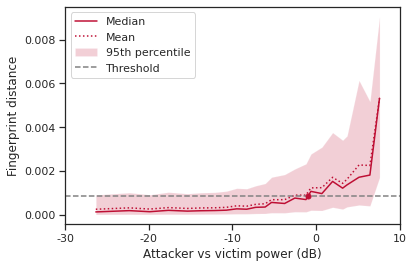

In [76]:
#ds = distances_all_avr
ds = { k: v for k, v in distances_all_avr.items() if k >= -30 }
plot_distances(ds, distances_zero=distances_all[0], draw_crossing=True, output_pdf='distances-hardware.pdf')

In [53]:
# Get crossing point table
print(crossing_points_table({ 'Hardware': distances_all_avr }, distances_all[0], median=True))

\begin{tabular}{lr}
\toprule
{} &  Crossing point (dB) \\
\midrule
Hardware &              -0.9394 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16102/4029896916.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex()


# Processing 2: Synthetic Boogaloo

Looking at synthetic jamming signals here.

### Dataset Setup

In [24]:
ds_0 = load_data(0)
id_cells_0 = get_id_cell(ds_0.ids_array, ds_0.cells_array)

In [25]:
dataset_size = 5000

# Take dataset_size elements from dss[0] for the anchor dataset, and another (disjoint) dataset_size elements for the test dataset
indices = np.random.choice(np.arange(len(ds_0)), size=dataset_size*2, replace=False)
indices_anchor = indices[:dataset_size]
indices_test = indices[dataset_size:]

id_cells_anchor = id_cells_0[indices_anchor]
samples_anchor = ds_0.samples_array[indices_anchor]
embeddings_anchor = get_embeddings(model, samples_anchor, autoencoder=models[0]['autoencoder'])

id_cells_array = id_cells_0[indices_test]
samples_array = ds_0.samples_array[indices_test]

2024-01-15 10:48:20.915447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-01-15 10:48:21.977066: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-01-15 10:48:22.078795: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


### Helpers

In [26]:
def samples_array_noisy(samples_array: np.ndarray, noise_function: callable, noise_amplitude: float):
    """
    Create a noisy version of the given samples array.

    Args:
        samples_array (np.ndarray): Samples to add noise to.
        noise_function (callable): Function to create the noise.
        noise_amplitude (float): Amplitude of the noise.
    """
    return samples_array + noise_function(noise_amplitude, samples_array.shape)

In [27]:
def get_distances_noisy(embeddings_anchor: np.ndarray, id_cells_anchor: np.ndarray, samples_array: np.ndarray, id_cells_array: np.ndarray, noise_function: callable, noise_amplitude: float, num_inputs: Optional[int] = None, avr: bool = False):
    samples_temp = samples_array if num_inputs is None else samples_array[:num_inputs]
    id_cells_temp = id_cells_array if num_inputs is None else id_cells_array[:num_inputs]
    noise_temp = noise_function(noise_amplitude, samples_temp.shape)
    samples_noisy_temp = samples_temp + noise_temp
    embeddings_temp = get_embeddings(model, samples_noisy_temp, autoencoder=models[0]['autoencoder'])

    distances_n = []
    for id_cell in np.unique(id_cells_anchor):
        embeddings_a = embeddings_anchor[id_cells_anchor == id_cell]
        embeddings_b = embeddings_temp[id_cells_temp == id_cell]
        if len(embeddings_b) > 0:
            distances = get_distances(np.concatenate([embeddings_a, embeddings_b]))
            # Get distances for all pairs from a to b
            distances_a_b = distances[:len(embeddings_a), len(embeddings_a):].flatten()
            distances_n.append(distances_a_b)
    if avr:
        avr = attacker_victim_ratio(noise_temp, samples_temp, False)
        return np.concatenate(distances_n), avr
    else:
        return np.concatenate(distances_n)

In [28]:
def get_distances_noisy_all(embeddings_anchor: np.ndarray, id_cells_anchor: np.ndarray, samples_array: np.ndarray, id_cells_array: np.ndarray, noise_function: callable, noise_amplitudes: list[float], num_inputs: Optional[int] = None, avr: bool = False):
    """
    Get the distances for the given noise amplitudes.
    """
    distances_noisy = dict()
    for noise_amplitude in tqdm(noise_amplitudes):
        if avr:
            dist, avr = get_distances_noisy(embeddings_anchor, id_cells_anchor, samples_array, id_cells_array, noise_function, noise_amplitude, num_inputs, avr)
            distances_noisy[avr] = dist
        else:
            distances_noisy[noise_amplitude] = get_distances_noisy(embeddings_anchor, id_cells_anchor, samples_array, id_cells_array, noise_function, noise_amplitude, num_inputs)
    return distances_noisy

In [29]:
def get_avrs_all(samples_array: np.ndarray, noise_function: callable, noise_amplitudes: list[float], num_inputs: Optional[int] = None) -> dict[float, float]:
    """
    Get the AVR for all noise amplitudes.
    """
    samples_temp = samples_array if num_inputs is None else samples_array[:num_inputs]

    avrs = dict()
    for noise_amplitude in tqdm(noise_amplitudes):
        noise_temp = noise_function(noise_amplitude, samples_temp.shape)
        avrs[noise_amplitude] = attacker_victim_ratio(noise_temp, samples_temp)

    return avrs

In [30]:
def find_amplitude(samples_array: np.ndarray, noise_function: callable, avr_target: float, num_inputs: Optional[int] = None, epsilon: float = 0.01, max_iters: Optional[int] = None) -> float:
    """
    For a given noise function, find the amplitude required to get the target AVR using a binary search.
    """

    samples_temp = samples_array if num_inputs is None else samples_array[:num_inputs]

    noise_amplitude = 0.5
    avr = 0.0
    # Establish upper bound
    while True:
        noise_temp = noise_function(noise_amplitude, samples_temp.shape)
        avr = attacker_victim_ratio(noise_temp, samples_temp)
        if avr > avr_target:
            break
        noise_amplitude *= 2

    # Binary search
    noise_amplitude_lower = noise_amplitude / 2 if noise_amplitude > 0.5 else 0
    noise_amplitude_upper = noise_amplitude
    while max_iters is None or max_iters > 0:
        noise_amplitude = (noise_amplitude_lower + noise_amplitude_upper) / 2
        noise_temp = noise_function(noise_amplitude, samples_temp.shape)
        avr = attacker_victim_ratio(noise_temp, samples_temp)
        if abs(avr - avr_target) < epsilon:
            break
        if avr > avr_target:
            noise_amplitude_upper = noise_amplitude
        else:
            noise_amplitude_lower = noise_amplitude
        if max_iters is not None:
            max_iters -= 1

    if max_iters is not None and max_iters == 0:
        print("Warning: max_iters reached")

    return noise_amplitude

In [31]:
def get_avr_distances(samples_array: np.ndarray, id_cells_array: np.ndarray, noise_function: callable, avrs: list[float], num_inputs_search: int, num_inputs_final: int, epsilon: float = 0.01, max_iters: Optional[int] = None):
    amplitudes = [ find_amplitude(samples_array, noise_function, avr, num_inputs_search, epsilon, max_iters=max_iters) for avr in tqdm(avrs) ]
    distances = get_distances_noisy_all(embeddings_anchor, id_cells_anchor, samples_array, id_cells_array, noise_function, amplitudes, num_inputs_final, avr=True)
    return distances

### Noise Functions

In [32]:
def gaussian_noise(amplitude: float, shape: tuple):
    """
    Create a Gaussian noise array with the given amplitude and shape.

    Args:
        amplitude (float): Amplitude of the noise.
        shape (tuple): Shape of the noise.
    """
    return np.random.normal(0, amplitude, shape)

In [33]:
def generate_rrc_impulse_response(sample_rate=100000, samples_per_symbol=1000, Beta=0.35, N=10):
    symbol_rate = sample_rate/samples_per_symbol
    Ts = 1/symbol_rate

    def get_impulse(x):
        if x == 0:
            return (1/Ts)*(1 + Beta*((4/np.pi - 1)))
        elif x == Ts/(4*Beta) or x == -Ts/(4*Beta):
            return (Beta/(Ts*np.sqrt(2)))*((1 + 2/np.pi)*((np.sin(np.pi/(4*Beta))) + (1-(2/np.pi)*np.cos(np.pi/(4*Beta)))))
        else:
            return (1/Ts) * ((np.sin((np.pi*x/Ts)*(1-Beta)) + (4*Beta)*(x/Ts) * np.cos((np.pi*x/Ts)*(1+Beta))) / (((np.pi*x)/Ts)*(1-((4*Beta*x)/Ts)**2)))

    xs = np.linspace(-N*Ts, N*Ts, 2*N*samples_per_symbol)
    impulse_response = np.vectorize(get_impulse)(xs)

    return impulse_response/np.sum(impulse_response)

def gaussian_noise_smooth(amplitude: float, length: int, oversampling: int):
    noise_base = gaussian_noise(amplitude, (length // oversampling, 2))
    # Fill in the rest with zeros, spacing out noise_base
    noise = np.zeros((length, 2))
    noise[::oversampling] = noise_base
    # Turn into complex numbers
    noise = noise[:, 0] + 1j * noise[:, 1]

    rrc_impulse_response = generate_rrc_impulse_response(sample_rate=25e6, samples_per_symbol=oversampling)
    noise = np.convolve(noise, rrc_impulse_response, mode='same')

    # Turn back into real numbers
    noise = np.stack([noise.real, noise.imag], axis=1)

    return noise

def gaussian_noise_smooth_fn(oversampling: int) -> callable:
    """
    Returns a noise function in the form expected by the get_distances_noisy_all function.
    """
    def noise_fn(amplitude: float, shape: tuple):
        if shape[-1] != 2:
            raise ValueError("Shape must end with 2")
        length = np.prod(shape[:-1])
        return gaussian_noise_smooth(amplitude, length, oversampling).reshape(shape)

    return noise_fn

In [34]:
# Load recorded noise
with open(os.path.join(data_base, "noise-recorded", "100-rrc.raw"), "rb") as f:
    noise_recorded = np.frombuffer(f.read(), dtype=np.float32)

# Convert complex numbers to reals, shape (,2)
noise_recorded = noise_recorded[::2] + 1j * noise_recorded[1::2]
noise_recorded = np.stack([noise_recorded.real, noise_recorded.imag], axis=1)

# Trim to the nearest multiple of 11000
noise_recorded = noise_recorded[:len(noise_recorded) // 11000 * 11000]

def recorded_noise(amplitude: float, shape: tuple):
    if shape[-1] != 2:
        raise ValueError("Shape must end with 2")
    length = np.prod(shape[:-1])
    noise = np.tile(noise_recorded, (length // noise_recorded.shape[0] + 1, 1))[:length]
    return noise.reshape(shape) * amplitude

In [35]:
# Tone jamming
def tone_jamming_noise(relative_frequency: float, sample_rate: int, offset: float):
    def noise_fn(amplitude: float, shape: tuple):
        if shape[-1] != 2:
            raise ValueError("Shape must end with 2")
        length = np.prod(shape[:-1])
        x = np.arange(length)
        o = offset * 2 * np.pi
        noise = np.stack([np.cos(((2 * np.pi * relative_frequency * x) / sample_rate) + o), np.sin(((2 * np.pi * relative_frequency * x) / sample_rate) + o)], axis=1)
        return noise.reshape(shape) * amplitude

    return noise_fn

### Running Analysis

In [36]:
distances = []
for id_cell in np.unique(id_cells[0]):
    es = embeddings[0][id_cells[0] == id_cell]
    if len(es) > 0:
        dists = get_distances(np.concatenate([es, es]))
        # Get distances for all pairs from a to b
        dists_a_b = dists[:len(es), len(es):].flatten()
        distances.append(dists_a_b)
distances_zero = np.concatenate(distances)

In [37]:
avrs = range(-18, 9)

noise_functions = {
    'Gaussian (recorded)': recorded_noise,
    'Gaussian (generated)': gaussian_noise_smooth_fn(50),
    'Tone jamming (0 Hz)': tone_jamming_noise(0, 25000000, 0.125),
    'Tone jamming (10 kHz)': tone_jamming_noise(10000, 25000000, 0.125),
}

distances_noisy = dict()

In [ ]:
for noise_function_name, noise_function in noise_functions.items():
    distances_noisy[noise_function_name] = get_avr_distances(samples_array, id_cells_array, noise_function, avrs, 100, 5000, max_iters=100)

In [251]:
# Save noise_functions
with open(os.path.join(data_base, "processed", "distances_noisy.pickle"), "wb") as f:
    pickle.dump(distances_noisy, f)

In [38]:
# Load noise functions
with open(os.path.join(data_base, "processed", "distances_noisy.pickle"), "rb") as f:
    distances_noisy = pickle.load(f)

In [56]:
avrs_tone_0 = range(9, 19)
distances_noisy_tone_0 = get_avr_distances(samples_array, id_cells_array, tone_jamming_noise(0, 25000000, 0.125), avrs_tone_0, 100, 5000, max_iters=100)

100%|██████████| 10/10 [01:33<00:00,  9.36s/it]


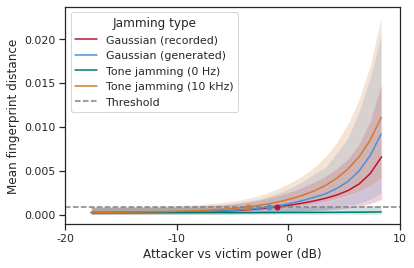

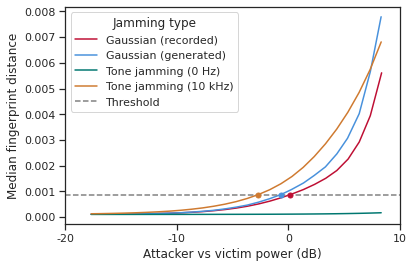

\begin{tabular}{lr}
\toprule
{} &  Crossing point (dB) \\
\midrule
Gaussian (recorded)   &               0.1834 \\
Gaussian (generated)  &              -0.6567 \\
Tone jamming (0 Hz)   &              16.2656 \\
Tone jamming (10 kHz) &              -2.6780 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16102/4029896916.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return df.to_latex()


In [81]:
plot_distances_multiple(distances_noisy, distances_zero, draw_crossing=True, draw_percentile=True, output_pdf='distances-noisy-percentile.pdf')
plot_distances_multiple(distances_noisy, distances_zero, draw_crossing=True, draw_percentile=False, output_pdf='distances-noisy.pdf', median=True)
#print(crossing_points_table(distances_noisy, distances_zero))
print(crossing_points_table({ k: (distances_noisy_tone_0 if '0 Hz' in k else v) for k, v in distances_noisy.items() }, distances_zero, median=True))

In [39]:
@plot
def plot_proportion_invalid(distances_noisy: dict[str, np.ndarray], distances_zero: np.ndarray, percentile: float = 95):
    percentile_threshold = np.percentile(distances_zero, percentile)

    new_data = dict()

    ax = None

    for name, distances_all in distances_noisy.items():
        new_data[name] = dict()
        for noise, distances in distances_all.items():
            new_data[name][noise] = np.mean(distances > percentile_threshold)

        if ax is None:
            ax = sns.lineplot(x=new_data[name].keys(), y=new_data[name].values(), label=name)
        else:
            sns.lineplot(x=new_data[name].keys(), y=new_data[name].values(), ax=ax, label=name)

    plt.axhline(y=0.5, linestyle="dotted", color="grey")

    plt.legend(loc='upper left', title="Jamming type")

    ax.set_xlabel("Attacker vs victim power (dB)")
    ax.set_ylabel("Proportion of invalid messages")

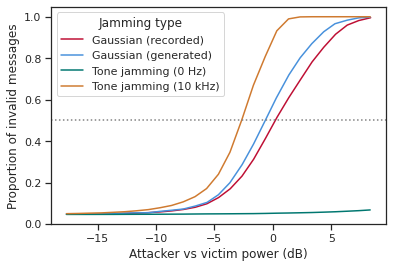

In [81]:
plot_proportion_invalid(distances_noisy, distances_zero, percentile=95, output_pdf='distances-noisy-invalid.pdf')

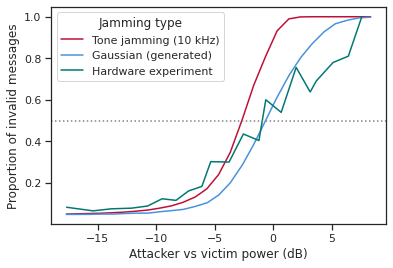

In [89]:
ds = { k: v for k, v in distances_all_avr.items() if k >= -19 }
plot_proportion_invalid({
    'Tone jamming (10 kHz)': distances_noisy['Tone jamming (10 kHz)'],
    'Gaussian (generated)': distances_noisy['Gaussian (generated)'],
    'Hardware experiment': ds
}, distances_zero, percentile=95)

In [40]:
import coding
from scipy import special

In [42]:
# Define standard functions
bers = 10**np.arange(-2, np.log10(5), 0.01)

JSR = np.arange(10**(-18/10), 10**(8/10), 0.01)

bits_per_symbol = 2

EbN0s = (1/ JSR * (1/bits_per_symbol))

BPSK_new = lambda EbN0: 0.5 * special.erfc(np.sqrt(EbN0))
bch_errors = np.vectorize(lambda ber: coding.bch_error_rate(ber, data_length=21, parity_length=10, t=2, interleave_depth=3, symbol_size=2)["equivalent_ber"])
bch_packet_errors = np.vectorize(lambda ber: coding.bch_error_rate(ber, data_length=21, parity_length=10, t=2, interleave_depth=3, symbol_size=2)["packet_error_rate"])

In [58]:
@plot
def plot_proportion_invalid_with_required_jammer(distances_noisy: dict[str, np.ndarray], distances_zero: np.ndarray, percentile: float = 95):
    percentile_threshold = np.percentile(distances_zero, percentile)

    new_data = dict()

    ax = plt.gca()

    JSR_dB = 10*np.log10(JSR)
    #ax.plot(1 - 10*np.log10(EbN0s*bits_per_symbol), packet_error_rate(BPSK_new(EbN0s)), label="None")
    ax.plot(JSR_dB, bch_packet_errors(BPSK_new(EbN0s)), label="Gaussian (decoder error)", linestyle='--')
    #ax.plot(1 - 10*np.log10(EbN0s*bits_per_symbol), bch_packet_errors(BPSK_new(EbN0s)), label="Gaussian (decoder error)", linestyle='--')

    for name, distances_all in distances_noisy.items():
        new_data[name] = dict()
        for noise, distances in distances_all.items():
            new_data[name][noise] = np.mean(distances > percentile_threshold)

        if ax is None:
            ax = sns.lineplot(x=new_data[name].keys(), y=new_data[name].values(), label=name)
        else:
            sns.lineplot(x=new_data[name].keys(), y=new_data[name].values(), ax=ax, label=name)

    plt.axhline(y=0.5, linestyle="dotted", color="grey")

    # Font size 10.5
    plt.legend(loc='upper center', title="Jamming type", ncol=2, bbox_to_anchor=(0.43, 1.3), fontsize=10.3)

    ax.set_xlabel("Attacker vs victim power (dB)")
    ax.set_ylabel("Proportion of invalid messages")

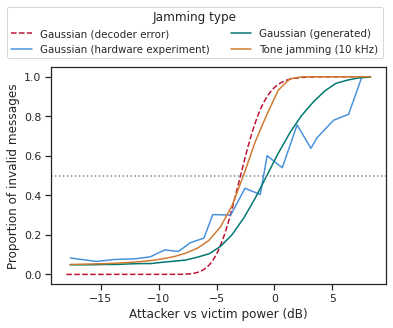

In [59]:
ds = { k: v for k, v in distances_all_avr.items() if k >= -19 }
plot_proportion_invalid_with_required_jammer({
    'Gaussian (hardware experiment)': ds,
    'Gaussian (generated)': distances_noisy['Gaussian (generated)'],
    'Tone jamming (10 kHz)': distances_noisy['Tone jamming (10 kHz)'],
}, distances_zero, percentile=95, output_pdf='distances-noisy-invalid-with-decoder.pdf')

In [61]:
{ k: np.mean(v > np.percentile(distances_zero, 95)) for k, v in distances_noisy['Tone jamming (10 kHz)'].items() }

{-17.664644434827114: 0.05052526263131566,
 -16.658154314324094: 0.0515674503918626,
 -15.657233532475857: 0.05302651325662831,
 -14.671466343359686: 0.05431882607970652,
 -13.6601456593791: 0.05707020176755044,
 -12.67019762801625: 0.05994663998666,
 -11.668896869369405: 0.06444889111222278,
 -10.659684068143855: 0.07007670501917626,
 -9.656351878829252: 0.07916458229114558,
 -8.668467023008402: 0.09012839753209938,
 -7.670902782459037: 0.10755377688844422,
 -6.663573405021397: 0.13248290812072702,
 -5.673220616341759: 0.17158579289644824,
 -4.661270347356042: 0.24053693513423377,
 -3.6753232851913875: 0.3465065866266467,
 -2.6655034399261712: 0.502042688010672,
 -1.6660239406893995: 0.6699182924795731,
 -0.6569717053082996: 0.8081123895280974,
 0.3348905965288992: 0.932216108054027,
 1.3370865585362302: 0.9896198099049525,
 2.325423157414683: 0.9992079373019843,
 3.3374242604656157: 1.0,
 4.338826395041947: 1.0,
 5.335563919782562: 1.0,
 6.342983827103344: 1.0,
 7.335386357800024: 1.

## Plotting Noise Functions

In [84]:
noise_samples = dict()
for name, noise_function in noise_functions.items():
    amplitude = find_amplitude(samples_array, noise_function, -10, 100, 0.01, max_iters=100)
    noise_samples[name] = noise_function(amplitude, samples_array[0].shape)

In [150]:
# Plot a single sample
@plot
def plot_sample_noises(sample, noise_samples, figsize=5):
    fig, axs = plt.subplots(nrows=2, ncols=len(noise_samples), figsize=(len(noise_samples)*figsize, 2*figsize), sharex=True, sharey=True)
    for i, (name, noise_sample) in enumerate(noise_samples.items()):
        ax = axs[0][i]
        marker = ('0 Hz' in name)
        ax.plot(noise_sample[:,0], noise_sample[:,1], marker='.' if marker else None)
        ax.set_title(name)
        ax.title.set_size(20)
        #if i == 0:
        #    ax.set_ylabel('Amplitude (Imaginary)')
        #ax.set_title(name)

        ax = axs[1][i]
        sample_with_noise = sample + noise_sample
        ax.plot(sample_with_noise[:,0], sample_with_noise[:,1])
        #ax.set_xlabel('Amplitude (Real)')
        #if i == 0:
        #    ax.set_ylabel('Amplitude (Imaginary)')

    # Ensure aspect ratio is 1:1
    for ax in axs.flatten():
        ax.set_aspect('equal', 'box')

    # Set global x and y labels
    fig.text(0.518, 0.01, 'Amplitude (Real)', ha='center', va='center', size=20)
    fig.text(0.00, 0.507, 'Amplitude (Imaginary)', ha='center', va='center', rotation='vertical', size=20)

    # Set x, y ticks
    for ax in axs.flatten():
        ax.set_xticks([-0.01, -0.005, 0, 0.005, 0.01])
        ax.set_yticks([-0.01, -0.005, 0, 0.005, 0.01])
        ax.tick_params(labelsize=16)

    plt.tight_layout()

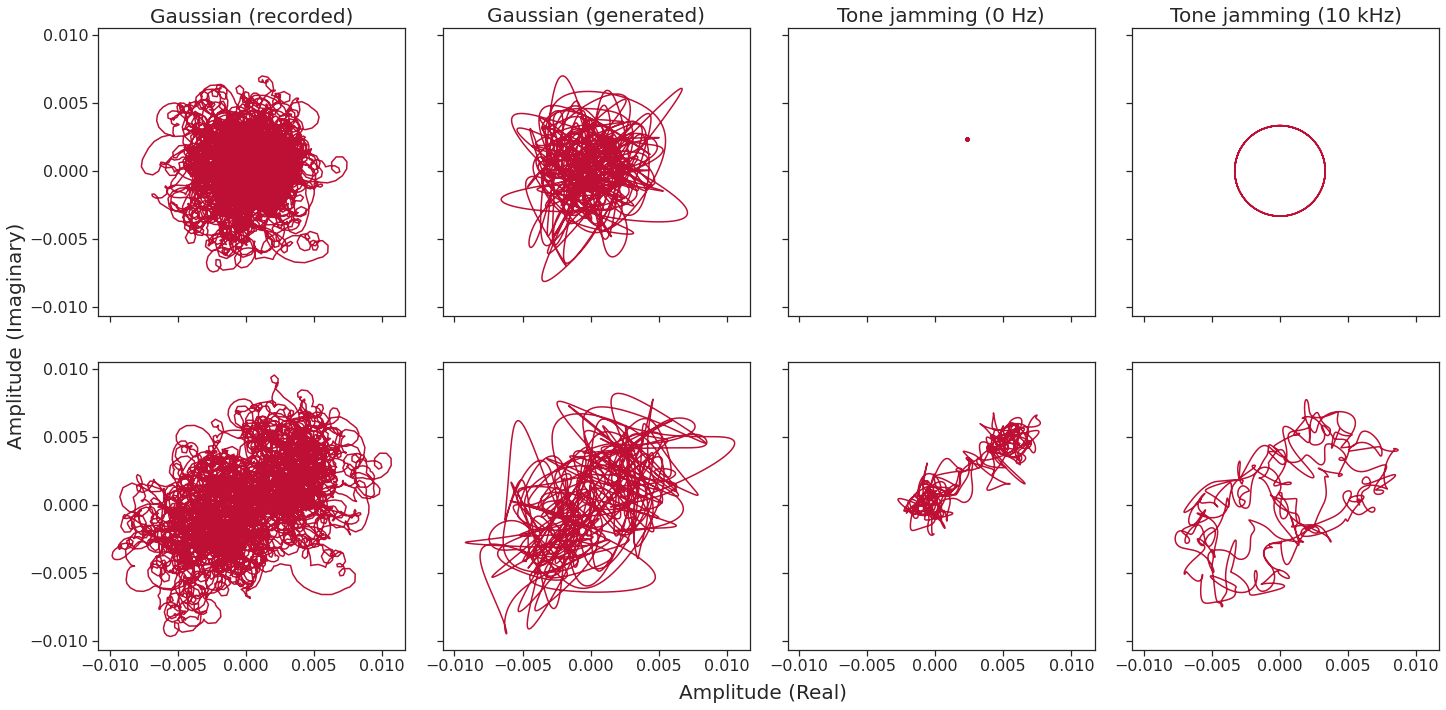

In [151]:
plot_sample_noises(samples_array[2], noise_samples, output_pdf='sample-noises.pdf')